<a href="https://colab.research.google.com/github/Anupurba-iitpkd/Mini_project_Extraction_of_Effective_visual_words_from_images_for_unsupervised_Learning/blob/main/effective_visual_word_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip uninstall opencv-python -y
!pip3 install --upgrade opencv-python==4.4.0.42

Uninstalling opencv-python-4.1.2.30:
  Successfully uninstalled opencv-python-4.1.2.30
     |████████████████████████████████| 49.4MB 80kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
import numpy as np
import cv2
from sklearn.mixture import GaussianMixture as GMM
import cv2
import matplotlib.pyplot as plt
import os
from skimage.io import imsave
import pickle

cv2.__version__


'4.1.2'

In [ ]:
#paths : Path in google drive where the image dataset is stored and where the 
#segmented images and indivisual segments are to be stored after code runs  

#root directory :
root_path = "/content/drive/MyDrive/Mini Project"

dataset_path = root_path + "/dataset100"
result_path = root_path + "/result"
indivisual_segment_path = root_path + "/segments"

print(root_path)
print(dataset_path)
print(result_path)
print(indivisual_segment_path)

os.listdir(dataset_path)

# Feature Extraction Step

In [ ]:
#code for segmenting the images using gaussian mixture models, visualizing them and storing them in the google drive 



#function for determining the ideal number of clusters for each class of images. 
def determine_n_clusters(category,source_path):

    #TODO : add the AIC or BIC elbow method for GMM

    if str.__contains__(category,"nonburst"):
        return 2
    else:
        return 3

#function for visualizing the segmented images
def visualize_clusters(file_name,labels):

    plt.figure(figsize=(10,10))
    #x = cv2.cvtColor(labels,cv2.COLOR_BGR2RGB)
    plt.imshow(labels)
    plt.title(str("segmented_"+file_name))
    imsave(file_name,labels)

#function to segment images by fitting pixel intensity values to a GMM : 
def segment_images(dataset_path,root_path):

    root_files = os.listdir(dataset_path) #extracting the class names
    n_components_list = {}
    gmm_dict_all_class = {} #dictionery storing class wise images.

    for category in root_files:

      source_path = dataset_path + "/" + category #path from where original images are taken.
      dest_path = root_path + "/result/" + category  #path where segmented images(containing all clusters) is stored. 
      gmm_dict = {} #dictionery storing image wise labels of one class
      gmm_labels_all = [] #list storing labels of all the classes : lists of lists -> one list is for one image
      image_list = os.listdir(source_path) #list of all images under a certain class

      
      n_components = determine_n_clusters(category,source_path) #function to return the ideal number of clusters for segmentation 
      #of images under a particular class. 
      n_components_list[category] = n_components #list of the number of clusters required for image of each label

      for image in image_list:

            #read the image :
            img = cv2.imread(str(source_path + "/" + image))
            print("shape of ", image , "is ", img.shape)

            #reshaping into a proper size :
            img2 = img.reshape((-1,3))
            print("reshaped dimensions of  ", image , "is ", img2.shape) #the dimensions of the image is - height X width x no. of channels and we are converting a 3d 
            #image to a 2d image, because GMM takes 2D array only. The shape of img2 is HeightxWidth , Channels

            #fitting the model to GMM:
            gmm_model = GMM(n_components=n_components, covariance_type='full').fit(img2)
            print("image data fit to GMM")

            #getting the labels : 
            gmm_labels = gmm_model.predict(img2)
            print("labels os ", image, " are ", gmm_labels)
            gmm_dict[image] = gmm_labels #key value pair of image names and corresponding GMM labels
            gmm_labels_all.append(gmm_labels) #also appending the labels of each image in a list, for backup.

            #again resizing the labels to visualise the clusters:
            gmm_labels = gmm_labels.reshape((img.shape[0],img.shape[1])) 
            filename = str(dest_path + '/' + image)
            
            #visualising the segmented image:
            visualize_clusters(filename,gmm_labels)
            print("image saved in path : ", filename)

      gmm_dict_all_class[category] = gmm_dict #dictionery of dictionery, category wise labels                    
        
    return gmm_dict_all_class,n_components_list,img.shape

#variable shape stores shape of images
#variable all_clas_labels is a dictionery of dictionery, storing category wise labels 
all_clas_labels,clusters,shape = segment_images(dataset_path,root_path)

#the intermideate data structures generated here are dumped using pickle.
outfile = open("/content/drive/MyDrive/Mini Project/gmm_dict_all_classes",'wb')
pickle.dump(all_clas_labels,outfile)
outfile.close()
outfile = open("/content/drive/MyDrive/Mini Project/cluster_dict_all_classes",'wb')
pickle.dump(clusters,outfile)
outfile.close()

In [ ]:
#function to extract indivisual segments from the entire image : one segment contains only one component of the image.
#for burst images, the components are burst, noise and fore ground. 
#for non burst images, the components are non burst, foreground
def extract_clusters(all_class_labels,dest_path,n_components_list,shape):

  
  for category_name,data in all_clas_labels.items():

      count = 0
      n_components = n_components_list[category_name]
      dest_path_ = dest_path + "/" + category_name

      for image_name, labels in data.items():
        
        gmm_labels_temp = labels #temporarily storing the gmm labels in this list.

        for i in range(n_components):

          filter_array = np.ndarray(labels.shape) #filtered array
          for j in range(len(gmm_labels_temp)):

            if gmm_labels_temp[j] == i:
              filter_array[j] = 255
            else :
              filter_array[j] = 0

          count = count+1
          print(count) #counter variable for debugging purpose

          extracted_segment = filter_array.reshape(shape[0],shape[1])
          file_name = str(dest_path_ + "/" + "segment_" + str(i) + "_" + image_name)
          #visualize_clusters(file_name,extracted_segment)
          imsave(file_name,extracted_segment)


extract_clusters(all_clas_labels,indivisual_segment_path,clusters,shape)



In [ ]:
#list of images from where image has to be extracted
categories = os.listdir(indivisual_segment_path)

segmented_images_dict = {}

for cat in categories:

  segmented_images_dict[cat] = os.listdir(indivisual_segment_path+"/"+cat)

print(segmented_images_dict)
print(len(segmented_images_dict))
print(len(segmented_images_dict['burst']))

#the intermideate data structures generated here are dumped using pickle.
outfile = open("/content/drive/MyDrive/Mini Project/segmented_images_dict",'wb')
pickle.dump(segmented_images_dict,outfile)
outfile.close()


In [ ]:
#function to extract features from images using SIFT
def extract_features(extractor,file_path,segmented_images_dict):
  
  descriptor_dict = {} #stores all the descriptors class wise
  vector_dict = {} #dictionery of dictionery, key : class(burst or nonburst) and values: vectors_list
 
  descriptor_list = []
  descriptor_list_for_lda = []


  for category,image_name_list in segmented_images_dict.items():

      file_path_ = file_path + "/" + category
      vectors_list = {}

      for image in image_name_list:
          
          img_seg = cv2.imread(file_path_ + '/' + image) #taking one segmented image from the segmented images directory 
          kp, des = extractor.detectAndCompute(img_seg,None) #extracting the key points and feature descriptors
          #print("the key points are : ", kp)
          #print("the descriptors are : ", des)

          if des is not None:

            #stored results for image retrieval
            vectors_list[image] = des  #here descriptors of each image is stored, with image names as the keys.

            #input for kmeans
            descriptor_list.extend(des) #here, all the descriptors of all the images are stored. all as one list. 

            #inout for LDA
            descriptor_list_for_lda.append(des) #input for lda

      #category wise stored results for  retrieval
      descriptor_dict[category] = descriptor_list # category wise list of list 
      vector_dict[category] = vectors_list #category wise image based dictionery

  return vector_dict,descriptor_dict,vectors_list,descriptor_list,descriptor_list_for_lda
        
  

extractor = cv2.SIFT_create(30)
sift_vector_dict, sift_descriptor_dict , sift_vector_list,sift_descriptor_list,descriptor_list_for_lda = extract_features(extractor,indivisual_segment_path,segmented_images_dict)

#sift_vectors = dicitionery of dictioneries, storing the descriptors of each image w.r.t. the image name, which in turn
#is stored in another dictionery, w.r.t. class labels


#note : 
# sift descriptors always have descriptor length = 128
#orb descriptors always have descriptor length = 32

#note: The format of input for kmeans and for LDA are different, thus, different data structures are prepared for them.

In [ ]:
# the KMeans() method of CV2 package takes input only in the format of numpy.float32 numbers, thus, here, we are reshaoing and converting
#the data as per kmeans requirements standards.

descriptor_list_np = np.asarray(sift_descriptor_list)
#descriptor_list_np = descriptor_list_np.flatten()

print("input for kmeans : ",descriptor_list_np.shape)
#print("input for lda :",len(descriptor_list_for_lda))

In [ ]:
#dumping the files generated in the previous step to google drive
outfile = open("/content/drive/MyDrive/Mini Project/sift_descriptor_list",'wb')
pickle.dump(sift_descriptor_list,outfile)

outfile = open("/content/drive/MyDrive/Mini Project/sift_descriptor_dict",'wb')
pickle.dump(sift_descriptor_dict,outfile)

outfile = open("/content/drive/MyDrive/Mini Project/sift_vector_list",'wb')
pickle.dump(sift_vector_list,outfile)

outfile = open("/content/drive/MyDrive/Mini Project/sift_vector_dict",'wb')
pickle.dump(sift_vector_dict,outfile)

outfile = open("/content/drive/MyDrive/Mini Project/input_for_lda",'wb')
pickle.dump(descriptor_list_for_lda,outfile)
outfile.close()

# Extraction of Visual Words using K means clustering:

In [ ]:
# loading the input for Kmeans, that was dumped from the erlier part
import pickle 
with open("/content/drive/MyDrive/Mini Project/sift_descriptor_list",'rb') as f1:
  sift_descriptor_list = pickle.load(f1)

In [ ]:
# determinig the optimum number of clusters for K means using elbow method and silhoutte scores:

from sklearn.cluster import KMeans
import sklearn.metrics as metrics

wss = []
shilloutte_scores = []

for i in range(10,40):

  kmeans = KMeans(n_clusters=i)
  kmeans = kmeans.fit(descriptor_list_np)
  wss_iter = kmeans.inertia_ #inertia gives the sum of distance of all the points within a cluster from the centroid of that cluster.
  labels = kmeans.labels_
  ss = metrics.silhouette_score(descriptor_list_np,labels,metric='euclidean',sample_size=1000,random_state=200)
  shilloutte_scores.append(ss)
  print("silhoutte score of n_cluster =  ",i, "is", ss)
  wss.append(wss_iter) 

outfile = open("/content/drive/MyDrive/Mini Project/ssanalysis",'wb')
pickle.dump(shilloutte_scores,outfile)

outfile = open("/content/drive/MyDrive/Mini Project/inertia",'wb')
pickle.dump(wss,outfile)

outfile.close()

In [ ]:
#function to get keys from dictionery :
def get_key(value,dict_name):

    for key,val in dict_name.items():
      if np.array_equal(val,value):
        return key

    return "key_doesnt_exist"


#function to get visual words :
def extract_visual_words(n_clusters,descriptor_list,max_iter=None, epsilon=None,termination_criteria=None):

  desc_list = []
  visual_word_keys = []

  if max_iter == None:
    max_iter = 10
  if epsilon == None:
    epsilon = 1.0
  if termination_criteria == None:
    termination_criteria = cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER

  criteria = (termination_criteria,max_iter,epsilon)

  #print(len(desc_list))

  #desc_list = np.array(desc_list)
  #desc_list = np.float32(desc_list)
  ret,label,center = cv2.kmeans(descriptor_list,n_clusters,None,criteria,7,cv2.KMEANS_RANDOM_CENTERS)
  visual_words = center

  return ret,label,visual_words,desc_list



result,labels,visual_words,desc_list = extract_visual_words(30,descriptor_list)


In [ ]:
#dumping the visual words:
outfile = open("/content/drive/MyDrive/Mini Project/visual_words",'wb')
pickle.dump(visual_words,outfile)
outfile = open("/content/drive/MyDrive/Mini Project/visual_words_index",'wb')
pickle.dump(visual_words_index,outfile)
outfile.close()

# Quantizing the feature space:

In [ ]:
from scipy.cluster.vq import vq

def quantize_feature_descriptors(visual_words,descriptor_list):
  code_book = visual_words
  features = descriptor_list 

  arr1,arr2 = vq(features,code_book) #array 1 contains the mapping of descriptor list to the cluster that it 
  #belongs to(using integer labels for clusters)
  #array 2 contains the distance of the descriptor list from their corresponding clusters

  return arr1, arr2


arr1,arr2 = quantize_feature_descriptors(visual_words,sift_descriptor_list)

outfile = open("/content/drive/MyDrive/Mini Project/mapping_to_centroid",'wb')
pickle.dump(arr1,outfile)
outfile.close()

# All Matplotlib Visualizations used in the project report 

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 125.23 MiB | 16.85 MiB/s, done.
Resolving deltas: 100% (562/562), done.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


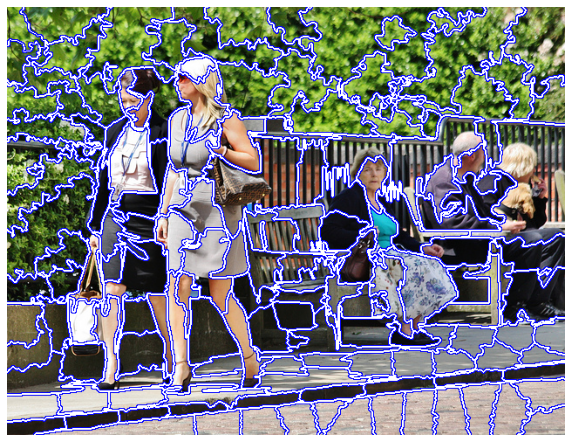

In [ ]:
!git clone https://github.com/matterport/Mask_RCNN



#implementation of SLIC
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float

from skimage import io
import matplotlib.pyplot as plt

img = img_as_float(io.imread("/content/Mask_RCNN/images/9247489789_132c0d534a_z.jpg"))
segments = slic(img,n_segments=250,compactness=10,sigma=1)
fig = plt.figure("Superpixel based segmentaton using SLIC",figsize=(10,10))
ax = fig.add_subplot(1,1,1)
ax.imshow(mark_boundaries(img,segments,color=(1,1,1),outline_color=(0,0,255)))
plt.axis("off")
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

No handles with labels found to put in legend.


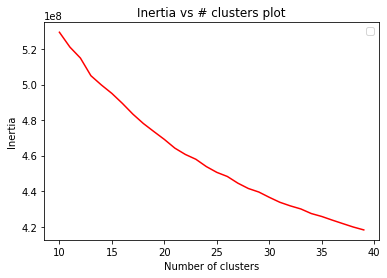

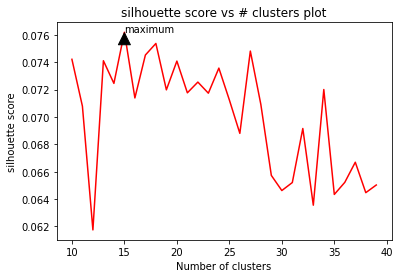

In [ ]:
#visualization of silhoutte score and elbow method for Kmeans clustering (Figure 12 (a),(b) in project report).

#importing the silhoutte scores
with open("/content/drive/MyDrive/Mini Project/ssanalysis",'rb') as f1:
  shilloutte_scores = pickle.load(f1)

#importing the inertia values:
with open("/content/drive/MyDrive/Mini Project/inertia",'rb') as f2:
  wss = pickle.load(f2)

#plot for elbow method
plt.plot(np.arange(10,40),wss,color='red')
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.title('Inertia vs # clusters plot')
plt.legend()
plt.show()

#Plot for silhoutte scores: 
max_y = np.max(shilloutte_scores)
max_x = int(shilloutte_scores.index(np.max(shilloutte_scores)) + 10)
x = np.arange(10,40)
plt.plot(x,shilloutte_scores,color='red')

plt.annotate('maximum',
              xy=(max_x,max_y),
              xytext = (max_x,max_y),
              arrowprops=dict(facecolor='black',shrink=0.25))


plt.xlabel("Number of clusters")
plt.ylabel("silhouette score")
plt.title('silhouette score vs # clusters plot')
plt.show()

In [ ]:
with open("/content/drive/MyDrive/Mini Project/mapping_to_centroid",'rb') as f3:
  arr1 = pickle.load(f3)

{0: 24, 1: 54, 2: 235, 3: 255, 4: 203, 5: 172, 6: 19, 7: 210, 8: 175, 9: 126, 10: 223, 11: 224, 12: 157, 13: 101, 14: 173, 15: 150, 16: 248, 17: 208, 18: 27, 19: 66, 20: 68, 21: 143, 22: 54, 23: 157, 24: 199, 25: 234, 26: 14, 27: 44, 28: 45, 29: 29}
{3: 255, 16: 248, 2: 235, 25: 234, 11: 224, 10: 223, 7: 210, 17: 208, 4: 203, 24: 199, 8: 175, 14: 173, 5: 172, 12: 157, 23: 157, 15: 150, 21: 143, 9: 126, 13: 101, 20: 68, 19: 66, 1: 54, 22: 54, 28: 45, 27: 44, 29: 29, 18: 27, 0: 24, 6: 19, 26: 14}


Text(0.5, 1.0, 'top ten most frequently occuring visual words , identified by their uique labels.(Total # visual words = 30)')

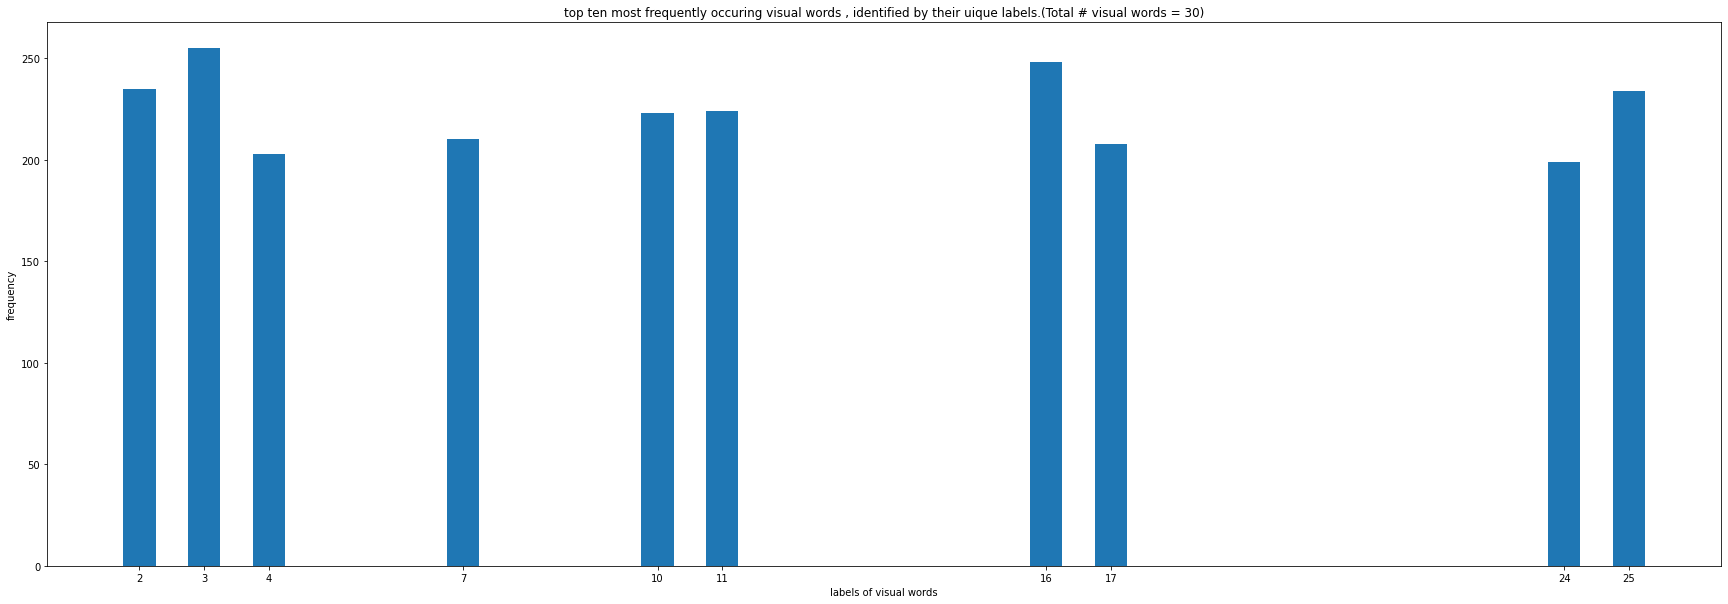

In [ ]:
#visualising the histogram of top 10 visual words in the project  :

#making a dictionery of cluster labels and corresponding frequency of occurance of words in that cluster:
d = dict(zip(np.unique(np.uint8(arr1)),np.uint8(np.bincount(arr1))))
print(d)

sorted_values = sorted(d.values(),reverse=True) # Sort the values
sorted_dict = {} #dictionery of labels and corresponding frequencies sorted on the basis of frequency values.

for i in sorted_values:
    for k in d.keys():
        if d[k] == i:
            sorted_dict[k] = d[k]
print(sorted_dict)

labels = []
frequency = []

#slicing the dictionery to extract the top 10 visual words
import itertools
d = dict(itertools.islice(sorted_dict.items(), 10))

for key,value in d.items():
      labels.append(key)
      frequency.append(value)
    

plt.figure(figsize=(30,10))
plt.bar(labels,frequency,width=0.5,align='center')
plt.xticks(labels)
plt.xlabel("labels of visual words")
plt.ylabel("frequency")
plt.title("top ten most frequently occuring visual words , identified by their uique labels.(Total # visual words = 30)")
#print(labels)
#print(frequency)


In [ ]:
#other image paths that I have used in the report are These can be replaced in the code of 
#SIFT,ORB,FAST to get the visualizations i used in the report :

lena = "/content/drive/MyDrive/Mini Project/Lenna_(test_image).png"
rose_daisy = "/content/drive/MyDrive/Mini Project/HK_Central_flowers_City_Hall_art_expo_Red_rose_n_Yellow_daisy_Nov-2012.jpg"
dog_cat = "/content/drive/MyDrive/Mini Project/dog_cat.jpg"

In [ ]:
#PIP version 4.4.0 is to be used for SIFT
!pip uninstall opencv-python -y
!pip3 install --upgrade opencv-python==4.4.0.42

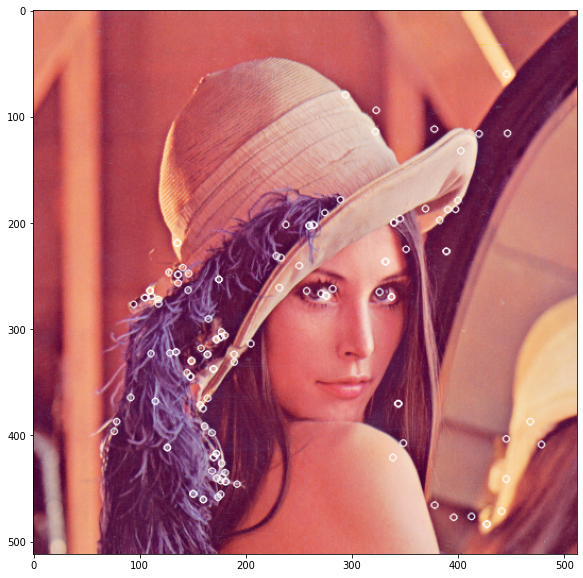

In [ ]:
#Visualizing the SIFT keypoints on respective images. The image path can be replaced to get other images.

#PLEASE NOTE: RUNNING SIFT USING CV2 REQUIRES VERSION 4.4.0 or more of CV2

import cv2
import matplotlib.pyplot as plt

sift = cv2.SIFT_create(128)
img_or = cv2.imread(lena)
img_or = cv2.cvtColor(img_or,cv2.COLOR_BGR2RGB)
img_sg = cv2.imread(lena)
kp, des = sift.detectAndCompute(img_sg,None)
img_1=cv2.drawKeypoints(img_or,kp,img_sg,color=(255,255,255))
plt.figure(figsize=(10,10))
plt.imshow(img_1)

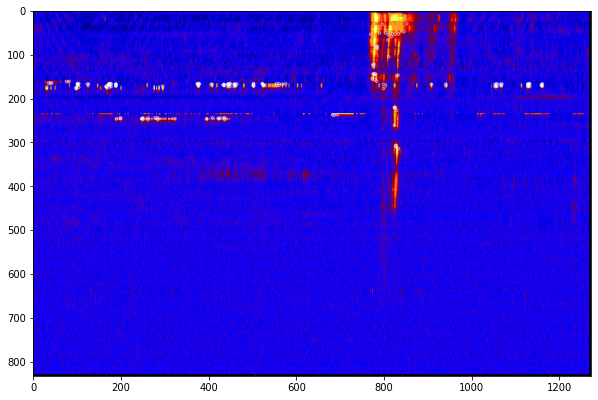

In [ ]:
#Visualizing the ORB keypoints on various images

import cv2 
orb = cv2.ORB_create(198)
img_or = cv2.imread("/content/drive/MyDrive/Mini Project/dataset100/burst/OOTY_20140416_063002_58.fit.gz.png")
img_or = cv2.cvtColor(img_or,cv2.COLOR_BGR2RGB)
img_sg = cv2.imread("/content/drive/MyDrive/Mini Project/segments/burst/segment_2_OOTY_20140416_063002_58.fit.gz.png")
kp = orb.detect(img_sg,None)
kp, des = orb.compute(img_sg,kp)
img2 = cv2.drawKeypoints(img_or, kp, None, color=(255,255,255), flags=0)
plt.figure(figsize=(10,10))
plt.imshow(img2)

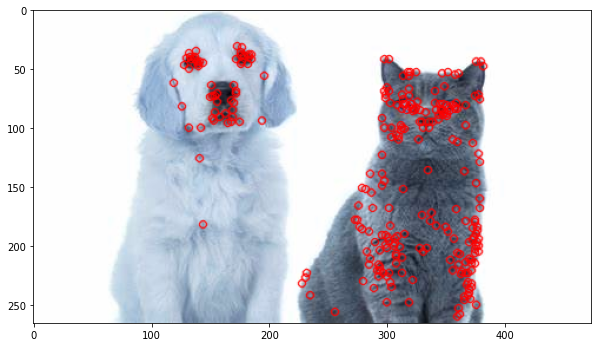

In [ ]:
import cv2
import matplotlib.pyplot as plt

fast = cv2.FastFeatureDetector_create(30)
img_or = cv2.imread(dog_cat)
img_sg = cv2.imread(dog_cat)
#fast.setNonmaxSuppression(0)
kp = fast.detect(img_sg,None)
img2 = cv2.drawKeypoints(img_or, kp, None, color=(255,0,0))
plt.figure(figsize=(10,10))
plt.imshow(img2)


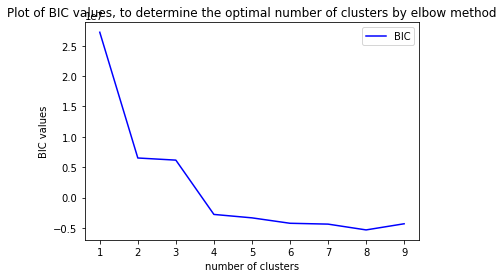

In [ ]:
#visualization of AIC and BIC values of the GMM model for burst and non burst images : 

with open("/content/drive/MyDrive/Mini Project/gmm_modela_1_to_10",'rb') as f4:
  gmm_models = pickle.load(f4)

#Image for which AIC and BIC values are plotted.
img = cv2.imread("/content/drive/MyDrive/Mini Project/dataset100/nonburst/OOTY_20140103_094435_58.fit.gz.png")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_rgb = img_rgb.reshape((-1,3))

bic = np.float32([m.bic(img_rgb) for m in gmm_models]) 
aic = np.float32([m.aic(img_rgb) for m in gmm_models]) 
plt.plot(n_components,bic,label='BIC',color='blue')
#plt.plot(n_components,aic,label='AIC',color='red')
plt.xlabel("number of clusters")
plt.ylabel("BIC values")
plt.legend()
plt.title("Plot of BIC values, to determine the optimal number of clusters by elbow method")
plt.show()


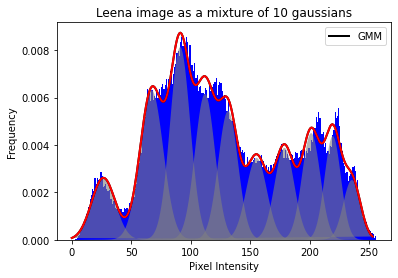

In [ ]:
#visualization of Histogram of an image fit to a mixture of Gaussians: 

#from sklearn.mixture import GaussianMixture as GMM

img = cv2.imread(lena)

b,g,r = cv2.split(img)
hist = cv2.calcHist([img],[0],None,[256],[0,256])
hist_b = cv2.calcHist([b],[0],None,[256],[0,256])
hist_g = cv2.calcHist([g],[0],None,[256],[0,256])
hist_r = cv2.calcHist([r],[0],None,[256],[0,256])
hist[0] = 0     # Removes background pixels
#print(type(hist))

data = img.ravel()
data = data[data != 0]
data = data[data != 1]  #Removes background pixels (intensities 0 and 1)

#data = data/255

#fit GMM
gmm = GMM(n_components = 10)
gmm = gmm.fit(X=np.expand_dims(data,1))

#evaluate GMM
gmm_x = np.linspace(0,253,256)
gmm_y = np.exp(gmm.score_samples(gmm_x.reshape(-1,1)))

# Plot histograms and gaussian curves
fig, ax = plt.subplots()
plt.hist(img.ravel(),256,[0,256],color="blue",density=True)
#plt.hist(b.ravel(),256,[0,256],color='blue',density=True)
#plt.hist(g.ravel(),256,[0,256],color='green',density=True)
#plt.hist(r.ravel(),256,[0,256],color='red',density=True)
ax.plot(gmm_x, gmm_y, color="black", lw=2, label="GMM")

ax.set_ylabel("Frequency")
ax.set_xlabel("Pixel Intensity")

plt.legend()
plt.title("Histogram of the OOTY_20140103_094435_58.fit.gz.png, fit to its gaussian")

from scipy import stats
plt.hist(img.ravel(),256,[0,256],color="blue",density=True)
plt.plot(gmm_x, gmm_y, color="red", lw=2, label="GMM")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.title("Leena image as a mixture of 10 gaussians")
for i in range(gmm.n_components):
  pdf = gmm.weights_[i] * stats.norm(gmm.means_[i,0],np.sqrt(gmm.covariances_[i,0])).pdf(gmm_x)
  plt.fill(gmm_x,pdf,facecolor='gray',edgecolor='none',alpha=0.6)


plt.show()

# Evaluaytion of LDA results; Forming the mappings

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.vq import vq
import pickle

In [ ]:
mapping = list(mapping)

#Extracting all the indices in the mapping to centroid which have 'x'.
#This shows that the descriptors in these indices in the sift_descriptor_list lies in cluster 'x'.
res = [x for x in range(len(mapping)) if mapping[x] == 21]

count = 0 
current_cluster = [] #all the descriptors that fall in the cluster number 'x' are in this list
for i in res:
  count = count+1
  current_cluster.append(sift_descriptor_list[i])



In [ ]:
#code for mapping images to visual words, that is, if image I contains words a,b,c, that mapping is present in this data structure.. 

image_to_cluster_map = {}
codebook = visual_words



length = 0 
for category,item in sift_vector_dict.items():
  for image_name,descriptors in item.items():

    features = descriptors
    map,distance = vq(features,code_book=codebook)
    image_to_cluster_map[length] = np.unique(map)
    length = length + 1

outfile = open("/content/drive/MyDrive/Mini Project/image_to_cluster_mapping",'wb')
pickle.dump(image_to_cluster_map,outfile)
outfile.close()

In [ ]:
#mapping cluster to SIFT features:

cluster_to_features_map = {}
for i in range(0,30):

  res = [x for x in range(len(mapping)) if mapping[x] == i]
  cluster_to_features_map[str('cluster '+str(i))] = res

In [ ]:
#if visual word V is present in images I,J,K, that mapping is present here. 

cluster_to_image_map = {}
for i in range(0,30):
  cluster_to_image_map[i] = []

image_indices = [] 
length = 0 

for category,item in segmented_images_dict.items():
  length = length + len(item)
  print(length)

image_indices = np.arange(0,length)


for c_index in range(0,30):

  for i_index in range(0,length):

    if c_index in image_to_cluster_map[i_index] and i_index  not in cluster_to_image_map[c_index]:

      cluster_to_image_map[c_index].append(i_index)
      

print(cluster_to_image_map[1])
print(image_indices)

# Supervised classification of images into burst and non burst : Naiive Approach

In [ ]:
#loading all the intermideate data : 


with open("/content/drive/MyDrive/Mini Project/lda_resultsTopic_10/top_word_list_10",'rb') as f1:
  top_10_words = pickle.load(f1)

with open("/content/drive/MyDrive/Mini Project/lda_resultsTopic_10/probs_words_10",'rb') as f1:
  probs_10_words = pickle.load(f1)

with open("/content/drive/MyDrive/Mini Project/lda_resultsTopic_20/top_word_list_20",'rb') as f1:
  top_20_words = pickle.load(f1)

with open("/content/drive/MyDrive/Mini Project/lda_resultsTopic_30/top_word_list_30",'rb') as f1:
  top_30_words = pickle.load(f1)

#loading the visual words(cluster centroids )
with open("/content/drive/MyDrive/Mini Project/visual_words",'rb') as f2:
  visual_words = pickle.load(f2)

#loading the descriptors : 
with open("/content/drive/MyDrive/Mini Project/sift_descriptor_list",'rb') as f3 : 
  sift_descriptor_list = pickle.load(f3)
  sift_descriptor_list = np.asarray(sift_descriptor_list)

with open("/content/drive/MyDrive/Mini Project/sift_descriptor_dict",'rb') as f4:
  sift_descriptor_dict = pickle.load(f4)

with open("/content/drive/MyDrive/Mini Project/sift_vector_list", 'rb') as f5 :
  sift_vector_list = pickle.load(f5)

with open("/content/drive/MyDrive/Mini Project/sift_vector_dict",'rb') as f6:
  sift_vector_dict = pickle.load(f6)

with open("/content/drive/MyDrive/Mini Project/mapping_to_centroid",'rb') as f7:
  mapping = pickle.load(f7)

with open("/content/drive/MyDrive/Mini Project/segmented_images_dict",'rb') as f8:
  segmented_images_dict = pickle.load(f8)

#loading the maps :
with open("/content/drive/MyDrive/Mini Project/cluster_to_image_map",'rb') as f9:
  cluster_to_image_map = pickle.load(f9)

with open("/content/drive/MyDrive/Mini Project/image_to_cluster_map",'rb') as f10:
  image_to_cluster_map = pickle.load(f10)

#with open("/content/drive/MyDrive/Mini Project/top_10_topic_classification",'rb') as f11:
#  top_10_topics_classification = pickle.load(f11)

with open("/content/drive/MyDrive/Mini Project/lda_resultsTopic_10/lda_generated_files/theta_1000","rb") as f1:
  theta_top_10 = pickle.load(f1)

In [ ]:
#list of all the images together (that is, irrespective of class)
segmented_images_list = []

for category,item in segmented_images_dict.items():

  segmented_images_list.extend(item)

print(segmented_images_list)
print(len(segmented_images_list))
print(type(segmented_images_list[0]))

['segment_0_OOTY_20140104_072958_58.fit.gz.png', 'segment_1_OOTY_20140104_072958_58.fit.gz.png', 'segment_2_OOTY_20140104_072958_58.fit.gz.png', 'segment_0_OOTY_20140105_041501_58.fit.gz.png', 'segment_1_OOTY_20140105_041501_58.fit.gz.png', 'segment_2_OOTY_20140105_041501_58.fit.gz.png', 'segment_0_OOTY_20140106_074458_58.fit.gz.png', 'segment_1_OOTY_20140106_074458_58.fit.gz.png', 'segment_2_OOTY_20140106_074458_58.fit.gz.png', 'segment_0_OOTY_20140106_074458_59.fit.gz.png', 'segment_1_OOTY_20140106_074458_59.fit.gz.png', 'segment_2_OOTY_20140106_074458_59.fit.gz.png', 'segment_0_OOTY_20140105_041501_59.fit.gz.png', 'segment_1_OOTY_20140105_041501_59.fit.gz.png', 'segment_2_OOTY_20140105_041501_59.fit.gz.png', 'segment_0_OOTY_20140108_034501_59.fit.gz.png', 'segment_1_OOTY_20140108_034501_59.fit.gz.png', 'segment_2_OOTY_20140108_034501_59.fit.gz.png', 'segment_0_OOTY_20140125_070000_58.fit.gz.png', 'segment_1_OOTY_20140125_070000_58.fit.gz.png', 'segment_2_OOTY_20140125_070000_58.fit.

In [ ]:
#finding out burst and non burst clusters: 
#images with indices < 150 are burst images.
#in the cluster to image maop, the burst image indices are replaced with 1 and non burst image indices are replaced with 0
clusters = {}
for cluster,image_list in cluster_to_image_map.items():

  temp = []
  for i_index in image_list:

    if i_index < 150:
      temp.append(0)
    else:
      temp.append(1)

  clusters[cluster] = temp

  
print(clusters)
print(len(clusters))

{0: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 1: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 2: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 3: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:


#finding the visual words that represent burst images and the ones that represent non burat images. 
#if 65% or more burst visual words in an image repreent burst clusters, the image is burst, otherwise non burst.

#dictionary clusters is the cluster to image map, i.e. one cluster mapped to all the images, whose descriptors belong to it .

burst_clusters = []
nonburst_clusters = []
noise = []

import collections

for cluster,image_list in clusters.items():

  frequency = collections.Counter(image_list)
  print("cluster ",cluster," " , frequency)

# we are setting the threshold such that if out of the n images belonging to a cluster, 
#if atleast 65% of them are burst images, then the cluster is labelled as a burst cluster. 
  threshold = 0.65*len(image_list) 
  print("length = ", len(image_list)," threshold =  ",threshold," ")

  if frequency[0] > threshold:
    #print("burst cluster ", cluster)
    burst_clusters.append(cluster)
  else:
    #print("non burst cluster", cluster)
    nonburst_clusters.append(cluster)

cluster  0   Counter({0: 48, 1: 38})
length =  86  threshold =   55.9  
cluster  1   Counter({0: 18, 1: 11})
length =  29  threshold =   18.85  
cluster  2   Counter({0: 86, 1: 51})
length =  137  threshold =   89.05  
cluster  3   Counter({0: 54, 1: 41})
length =  95  threshold =   61.75  
cluster  4   Counter({0: 65, 1: 22})
length =  87  threshold =   56.550000000000004  
cluster  5   Counter({0: 40, 1: 40})
length =  80  threshold =   52.0  
cluster  6   Counter({1: 48, 0: 34})
length =  82  threshold =   53.300000000000004  
cluster  7   Counter({0: 50, 1: 43})
length =  93  threshold =   60.45  
cluster  8   Counter({0: 49, 1: 36})
length =  85  threshold =   55.25  
cluster  9   Counter({1: 50, 0: 43})
length =  93  threshold =   60.45  
cluster  10   Counter({0: 56, 1: 35})
length =  91  threshold =   59.15  
cluster  11   Counter({0: 74, 1: 31})
length =  105  threshold =   68.25  
cluster  12   Counter({0: 59, 1: 8})
length =  67  threshold =   43.550000000000004  
cluster  1

In [ ]:
#dumping all the files.

outfile = open("/content/drive/MyDrive/Mini Project/cluster_to_image_map",'wb')
pickle.dump(cluster_to_image_map,outfile)
outfile = open("/content/drive/MyDrive/Mini Project/image_to_cluster_map",'wb')
pickle.dump(image_to_cluster_map,outfile)
outfile = open("/content/drive/MyDrive/Mini Project/list_of_burst_clusters",'wb')
pickle.dump(burst_clusters,outfile)
outfile = open("/content/drive/MyDrive/Mini Project/list_of_nonburst_clusters",'wb')
pickle.dump(nonburst_clusters,outfile)
outfile.close()

In [ ]:
#extracting which topic of the top 10 topics fall in the burst cluster list and which fall in the non burst cluster list

#words are actually cluster centroids and if a word falls in the list of burst clusters.
#its phi value is added to the burst probability and otherwise, it is added to non burst probability.

top_10_topics_classification = {}
top_20_topics_classification = {}
top_30_topics_classification ={}
top_10_burst_probs = []

t_index = 0
for i in range(len(top_10_words)):

  burst_count = 0
  nonburst_count = 0
  burst_list = []
  nonburst_list = []
  probs_burst = 0
  probs_nonburst = 0

  for j in range(len(top_10_words[i])):

    if top_10_words[i][j] in burst_clusters : 

      #print("burst cluster")
      burst_count = burst_count + 1
      burst_list.append(top_10_words[i][j])
      probs_burst = probs_burst + probs_10_words[i][j]

    elif top_10_words[i][j] in nonburst_clusters:

      #print("non burst cluster")
      nonburst_count = nonburst_count + 1
      nonburst_list.append(j)
      probs_nonburst = probs_nonburst + probs_10_words[i][j]

  
  top_10_burst_probs.append(probs_burst)
  top_10_topics_classification[t_index] = {"burst cluster" : (burst_count,burst_list,probs_burst) , "non_burst_cluster" : (nonburst_count,nonburst_list,probs_nonburst)}
  t_index = t_index + 1    

In [ ]:
for t_index,dictionery in top_10_topics_classification.items():
  print("topic ", t_index ,dictionery)
  


#outfile = open("/content/drive/MyDrive/Mini Project/top_10_topic_classification",'wb')
#pickle.dump(top_10_topics_classification,outfile)
#outfile.close()

#outfile = open("/content/drive/MyDrive/Mini Project/top_20_topic_classification",'wb')
#pickle.dump(top_20_topics_classification,outfile)
#outfile.close()


outfile = open("/content/drive/MyDrive/Mini Project/top_30_topic_classification",'wb')
pickle.dump(top_30_topics_classification,outfile)
outfile.close()




topic  0 {'burst cluster': (4, [28, 29, 22, 16], 0.13998005982053838), 'non_burst_cluster': (6, [0, 1, 2, 4, 7, 8], 0.854037886340977)}
topic  1 {'burst cluster': (7, [27, 4, 19, 25, 11, 14, 24], 0.775306479859895), 'non_burst_cluster': (3, [2, 5, 9], 0.2211908931698774)}
topic  2 {'burst cluster': (3, [21, 4, 27], 0.68983286908078), 'non_burst_cluster': (7, [2, 3, 4, 5, 7, 8, 9], 0.3073816155988857)}
topic  3 {'burst cluster': (4, [11, 25, 27, 19], 0.15690140845070424), 'non_burst_cluster': (6, [0, 1, 2, 3, 5, 9], 0.8402816901408451)}
topic  4 {'burst cluster': (5, [14, 26, 29, 28, 22], 0.6958433253397283), 'non_burst_cluster': (5, [2, 6, 7, 8, 9], 0.3017585931254996)}
topic  5 {'burst cluster': (5, [21, 25, 19, 4, 27], 0.3355640535372849), 'non_burst_cluster': (5, [0, 1, 4, 7, 8], 0.6606118546845123)}
topic  6 {'burst cluster': (5, [11, 25, 27, 24, 4], 0.41537132987910186), 'non_burst_cluster': (5, [1, 3, 4, 5, 8], 0.581174438687392)}
topic  7 {'burst cluster': (5, [28, 29, 22, 26, 1

In [ ]:
images = {}
for i in range(0,len(theta_top_10)):

#theta is the topic-image distribution, i.e. gives by what percent an image belongs to each of the top 10 topics
#calculating the burst probability of an image segment by multiplying the burst probability of the topic  
#with the probability by which the image belongs tp that topic and adding them

    sum_probs = 0
    for j in range(0,len(theta_top_10[0])):
      
        sum_probs = sum_probs + (theta_top_10[i][j] * top_10_burst_probs[j])
        #print("topic is :",j,"sum of theta  =",sum_probs)

        if j == 9:
          if i<150:
              images[i] = (segmented_images_list[i],sum_probs,"burst",1) 
          else :
              images[i] = (segmented_images_list[i],sum_probs,"nonburst",0) 

print(len(images))
print(images)

for category,info in images.items():
  print(category, "    ",info)


250
{0: ('segment_0_OOTY_20140104_072958_58.fit.gz.png', 0.2706040639465829, 'burst', 1), 1: ('segment_1_OOTY_20140104_072958_58.fit.gz.png', 0.3224127966238387, 'burst', 1), 2: ('segment_2_OOTY_20140104_072958_58.fit.gz.png', 0.20730097889740834, 'burst', 1), 3: ('segment_0_OOTY_20140105_041501_58.fit.gz.png', 0.40680570957509016, 'burst', 1), 4: ('segment_1_OOTY_20140105_041501_58.fit.gz.png', 0.6599240639521047, 'burst', 1), 5: ('segment_2_OOTY_20140105_041501_58.fit.gz.png', 0.645156800632322, 'burst', 1), 6: ('segment_0_OOTY_20140106_074458_58.fit.gz.png', 0.40695315052396686, 'burst', 1), 7: ('segment_1_OOTY_20140106_074458_58.fit.gz.png', 0.3582685062479011, 'burst', 1), 8: ('segment_2_OOTY_20140106_074458_58.fit.gz.png', 0.5095567815551586, 'burst', 1), 9: ('segment_0_OOTY_20140106_074458_59.fit.gz.png', 0.30191305508624044, 'burst', 1), 10: ('segment_1_OOTY_20140106_074458_59.fit.gz.png', 0.5422080211750712, 'burst', 1), 11: ('segment_2_OOTY_20140106_074458_59.fit.gz.png', 0.3

In [ ]:
#creating dataframe with the above generated info :

import pandas as pd 
df = pd.DataFrame(images.values(), columns = ['image name', 'burst_prob','label','ground_truth'])

In [ ]:
#original dataframe : 
print(df.head(5))

#shuffled dataframe
df_shuffled = df.sample(frac=1)
print(df_shuffled.head(5))

#dumping the dataframe:
outfile = open("/content/drive/MyDrive/Mini Project/df_classification_technique1",'wb')
pickle.dump(df_shuffled,outfile)
outfile.close()

                                     image name  ...  ground_truth
0  segment_0_OOTY_20140104_072958_58.fit.gz.png  ...             1
1  segment_1_OOTY_20140104_072958_58.fit.gz.png  ...             1
2  segment_2_OOTY_20140104_072958_58.fit.gz.png  ...             1
3  segment_0_OOTY_20140105_041501_58.fit.gz.png  ...             1
4  segment_1_OOTY_20140105_041501_58.fit.gz.png  ...             1

[5 rows x 4 columns]
                                       image name  ...  ground_truth
205  segment_1_OOTY_20140109_045959_58.fit.gz.png  ...             0
179  segment_1_OOTY_20140106_023000_59.fit.gz.png  ...             0
103  segment_1_OOTY_20140319_064500_58.fit.gz.png  ...             1
102  segment_0_OOTY_20140319_064500_58.fit.gz.png  ...             1
200  segment_0_OOTY_20140108_040001_58.fit.gz.png  ...             0

[5 rows x 4 columns]


In [ ]:
thresh_list = [0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90]
acc_list = []
cm_list = []
pres_list = []
recall_list = []
f1_list = []



y_pred_list = []

for threshold in thresh_list:

  y_pred = []
  for i,rows in df_shuffled.iterrows():

    if rows['burst_prob'] <threshold:
      y_pred.append(1) #burst images
    else:
      y_pred.append(0) #nonburst images
  y_pred_list.append(y_pred) #prediction output

y_test = df_shuffled['ground_truth'] #ground truth

In [ ]:
#evaluation of the naive approach by standard metrics

from sklearn.metrics import confusion_matrix,accuracy_score,f1_score,precision_score,recall_score

#metrics:
#precision_score : (true_positive/true_positive+false_positive) 
#The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

#recall_score : (true_positive/true_positive+false_negative)
#The recall is intuitively the ability of the classifier to find all the positive samples.

#F1 = 2 * (precision * recall) / (precision + recall)

for y in y_pred_list:


  cm = confusion_matrix(y_test,y)
  cm_list.append(cm)
  acc = accuracy_score(y_test,y)
  acc_list.append(acc)
  pres = precision_score(y_test,y)
  pres_list.append(pres)
  rec = recall_score(y_test,y)
  recall_list.append(rec)
  f1 = f1_score(y_test,y)
  f1_list.append(f1)


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


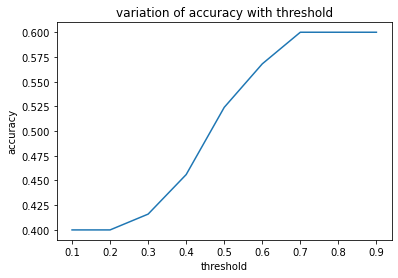

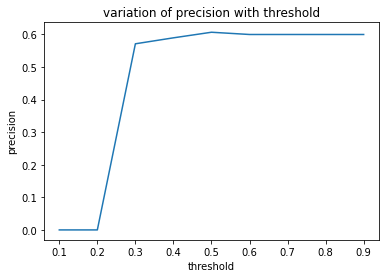

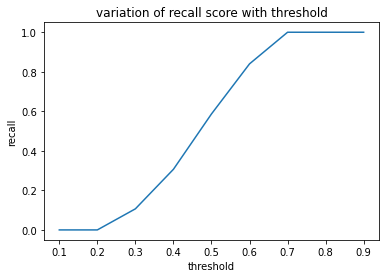

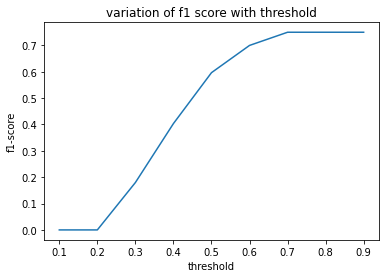

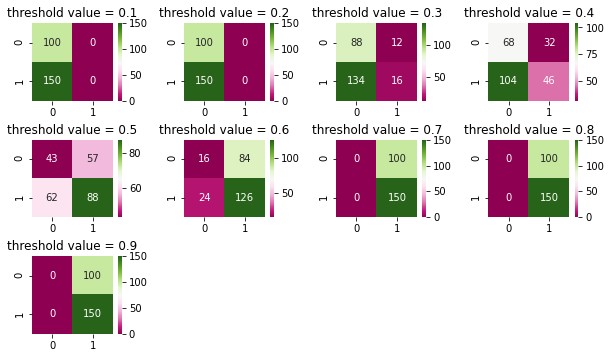

In [ ]:
import matplotlib.pyplot as plt

#plotting the accuracy vs threshold
plt.plot(thresh_list,acc_list)
plt.xlabel("threshold")
plt.ylabel("accuracy")
plt.title("variation of accuracy with threshold")
plt.show()

#plotting the precision vs threshold
plt.plot(thresh_list,pres_list)
plt.xlabel("threshold")
plt.ylabel("precision")
plt.title("variation of precision with threshold")
plt.show()

#plotting the recall score 
plt.plot(thresh_list,recall_list)
plt.xlabel("threshold")
plt.ylabel("recall")
plt.title("variation of recall score with threshold")
plt.show()

#plotting the f1 score
plt.plot(thresh_list,f1_list)
plt.xlabel("threshold")
plt.ylabel("f1-score")
plt.title("variation of f1 score with threshold")
plt.show()

#plotting the confusion matrix:
import seaborn as sns
fig = plt.figure(figsize=(10,10))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
rows = 5
columns = 4

for j in range(1,rows*columns+1):
  fig.add_subplot(rows,columns,j)
  sns.heatmap(cm_list[j-1],annot=True,fmt='d',cmap='PiYG') #BuPu, Blues, Greens, Reds,YlGnBu", vmin=0.5 to vmax=0.7 
  plt.title("threshold value = "+str(thresh_list[j-1]))

  if j == 9:
    break

plt.show()


In [ ]:
metrics = {'accuracy':acc_list,'precision':pres_list,'recall':recall_list,'f1_score':f1_list,'confusion matrix': cm_list}

metrics_df = pd.DataFrame(metrics,columns=['accuracy','precision','recall','f1_score','confusion matrix'])

#dumping the df of metrics : 
outfile = open("/content/drive/MyDrive/Mini Project/metrics_df",'wb')
metrics_df
pickle.dump(metrics_df,outfile)
outfile.close()

# Supervised Image Classification Technique; Based on topic modelling results

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

In [ ]:
#loading the visual words(cluster centroids )
with open("/content/drive/MyDrive/Mini Project/visual_words",'rb') as f2:
  visual_words = pickle.load(f2)

#loading the descriptors : 
with open("/content/drive/MyDrive/Mini Project/sift_descriptor_list",'rb') as f3 : 
  sift_descriptor_list = pickle.load(f3)
  sift_descriptor_list = np.asarray(sift_descriptor_list)

with open("/content/drive/MyDrive/Mini Project/sift_descriptor_dict",'rb') as f4:
  sift_descriptor_dict = pickle.load(f4)

with open("/content/drive/MyDrive/Mini Project/sift_vector_list", 'rb') as f5 :
  sift_vector_list = pickle.load(f5)

with open("/content/drive/MyDrive/Mini Project/sift_vector_dict",'rb') as f6:
  sift_vector_dict = pickle.load(f6)

with open("/content/drive/MyDrive/Mini Project/mapping_to_centroid",'rb') as f7:
  mapping = pickle.load(f7)

with open("/content/drive/MyDrive/Mini Project/segmented_images_dict",'rb') as f8:
  segmented_images_dict = pickle.load(f8)

#loading the maps :
with open("/content/drive/MyDrive/Mini Project/cluster_to_image_map",'rb') as f9:
  cluster_to_image_map = pickle.load(f9)

with open("/content/drive/MyDrive/Mini Project/image_to_cluster_map",'rb') as f10:
  image_to_cluster_map = pickle.load(f10)

#with open("/content/drive/MyDrive/Mini Project/top_10_topic_classification",'rb') as f11:
#  top_10_topics_classification = pickle.load(f11)

with open("/content/drive/MyDrive/Mini Project/r_list",'rb') as f12:
  r_list = pickle.load(f12)

with open("/content/drive/MyDrive/Mini Project/image_to_segment_map",'rb') as f11:
  image_to_segment_map = pickle.load(f11)

with open("/content/drive/MyDrive/Mini Project/lda_resultsTopic_10/lda_generated_files/theta_1000",'rb') as f1:
  theta_top_10 = pickle.load(f1)

In [ ]:
#creating a list of original IMage from the segmented images.

segmented_images_list = []

for category,item in segmented_images_dict.items():

  segmented_images_list.extend(item)

print(segmented_images_list)
print(len(segmented_images_list))
print(type(segmented_images_list[0]))

original_images_list = []
original_images_list.extend(os.listdir("/content/drive/MyDrive/Mini Project/dataset100/burst"))
original_images_list.extend(os.listdir("/content/drive/MyDrive/Mini Project/dataset100/nonburst"))

outfile = open("/content/drive/MyDrive/Mini Project/original_images_list",'wb')
pickle.dump(original_images_list,outfile)
outfile = open("/content/drive/MyDrive/Mini Project/segmented_images_list",'wb')
pickle.dump(segmented_images_list,outfile)
outfile.close()

print(original_images_list)
print(len(original_images_list))

['segment_0_OOTY_20140104_072958_58.fit.gz.png', 'segment_1_OOTY_20140104_072958_58.fit.gz.png', 'segment_2_OOTY_20140104_072958_58.fit.gz.png', 'segment_0_OOTY_20140105_041501_58.fit.gz.png', 'segment_1_OOTY_20140105_041501_58.fit.gz.png', 'segment_2_OOTY_20140105_041501_58.fit.gz.png', 'segment_0_OOTY_20140106_074458_58.fit.gz.png', 'segment_1_OOTY_20140106_074458_58.fit.gz.png', 'segment_2_OOTY_20140106_074458_58.fit.gz.png', 'segment_0_OOTY_20140106_074458_59.fit.gz.png', 'segment_1_OOTY_20140106_074458_59.fit.gz.png', 'segment_2_OOTY_20140106_074458_59.fit.gz.png', 'segment_0_OOTY_20140105_041501_59.fit.gz.png', 'segment_1_OOTY_20140105_041501_59.fit.gz.png', 'segment_2_OOTY_20140105_041501_59.fit.gz.png', 'segment_0_OOTY_20140108_034501_59.fit.gz.png', 'segment_1_OOTY_20140108_034501_59.fit.gz.png', 'segment_2_OOTY_20140108_034501_59.fit.gz.png', 'segment_0_OOTY_20140125_070000_58.fit.gz.png', 'segment_1_OOTY_20140125_070000_58.fit.gz.png', 'segment_2_OOTY_20140125_070000_58.fit.

In [ ]:
#image to segment map :
#creating image to segment map, that is suppose segment 0,1,2 are of image 0, that mapping is present here.
segment_path_burst = "/content/drive/MyDrive/Mini Project/segments/burst"
segment_path_nonburst = "/content/drive/MyDrive/Mini Project/segments/nonburst"
dataset_path_burst = "/content/drive/MyDrive/Mini Project/dataset100/burst"
dataset_path_nonburst = "/content/drive/MyDrive/Mini Project/dataset100/nonburst"

def image_to_segment_mapping(dataset_path,segment_path):

  count = 0
  d = {}
  for i in os.listdir(dataset_path):
    l = []
    for j in os.listdir(segment_path):
      if j.__contains__(i):
        l.append(j)
      d[count] = l
    
    count = count + 1
  return d

d_burst  = image_to_segment_mapping(dataset_path_burst,segment_path_burst)
d_nonburst = image_to_segment_mapping(dataset_path_nonburst,segment_path_nonburst)

d_1 = {}
for i,j in d_nonburst.items():
  i=i+50
  d_1[i]=j


print(d_1)

{50: ['segment_0_OOTY_20140228_043002_59.fit.gz.png', 'segment_1_OOTY_20140228_043002_59.fit.gz.png'], 51: ['segment_1_OOTY_20140228_043002_58.fit.gz.png', 'segment_0_OOTY_20140228_043002_58.fit.gz.png'], 52: ['segment_0_OOTY_20140228_044502_58.fit.gz.png', 'segment_1_OOTY_20140228_044502_58.fit.gz.png'], 53: ['segment_0_OOTY_20140225_063000_58.fit.gz.png', 'segment_1_OOTY_20140225_063000_58.fit.gz.png'], 54: ['segment_0_OOTY_20140225_113001_59.fit.gz.png', 'segment_1_OOTY_20140225_113001_59.fit.gz.png'], 55: ['segment_0_OOTY_20140225_113001_58.fit.gz.png', 'segment_1_OOTY_20140225_113001_58.fit.gz.png'], 56: ['segment_1_OOTY_20140226_035959_59.fit.gz.png', 'segment_0_OOTY_20140226_035959_59.fit.gz.png'], 57: ['segment_0_OOTY_20140226_040000_58.fit.gz.png', 'segment_1_OOTY_20140226_040000_58.fit.gz.png'], 58: ['segment_1_OOTY_20140103_101435_58.fit.gz.png', 'segment_0_OOTY_20140103_101435_58.fit.gz.png'], 59: ['segment_0_OOTY_20140103_094436_59.fit.gz.png', 'segment_1_OOTY_20140103_094

In [ ]:


org_image_index = range(0,50)
def image_to_segment_index_map(d):
  x = {}
  for i,j in d.items():
    l = []
    for img_name in j:
      if img_name in segmented_images_list:
        l.append(segmented_images_list.index(img_name))
        x[i] = l

  return x

x_burst = image_to_segment_index_map(d_burst)
x_nonburst = image_to_segment_index_map(d_1)
print(x_burst)
print(x_nonburst)



x = {**x_burst,**x_nonburst}
print(len(x))

#sumping the image to segment map
outfile = open("/content/drive/MyDrive/Mini Project/image_to_segment_map",'wb')
pickle.dump(x,outfile)
outfile.close()

{0: [0, 1, 2], 1: [3, 4, 5], 2: [6, 7, 8], 3: [9, 10, 11], 4: [12, 13, 14], 5: [15, 16, 17], 6: [18, 19, 20], 7: [21, 22, 23], 8: [24, 25, 26], 9: [27, 28, 29], 10: [30, 31, 32], 11: [33, 34, 35], 12: [36, 37, 38], 13: [39, 40, 41], 14: [42, 43, 44], 15: [45, 46, 47], 16: [48, 49, 50], 17: [51, 52, 53], 18: [54, 55, 56], 19: [57, 58, 59], 20: [60, 61, 62], 21: [63, 64, 65], 22: [66, 67, 68], 23: [69, 70, 71], 24: [72, 73, 74], 25: [75, 76, 77], 26: [78, 79, 80], 27: [81, 82, 83], 28: [84, 85, 86], 29: [87, 88, 89], 30: [90, 91, 92], 31: [93, 94, 95], 32: [96, 97, 98], 33: [99, 100, 101], 34: [102, 103, 104], 35: [105, 106, 107], 36: [108, 109, 110], 37: [111, 112, 113], 38: [114, 115, 116], 39: [117, 118, 119], 40: [120, 121, 122], 41: [123, 124, 125], 42: [126, 127, 128], 43: [129, 130, 131], 44: [132, 133, 134], 45: [135, 136, 137], 46: [138, 139, 140], 47: [141, 142, 143], 48: [144, 145, 146], 49: [147, 148, 149]}
{50: [150, 151], 51: [153, 152], 52: [154, 155], 53: [156, 157], 54: 

In [ ]:
#creating topic burst probability in supervised manner:

topic_0 = []
topic_1 = []
topic_2 = []
topic_3 = []
topic_4 = []
topic_5 = []
topic_6 = []
topic_7 = []
topic_8 = []
topic_9 = []

for i in range(0,len(theta_top_10)):

  topic_0.append(theta_top_10[i][0])
  topic_1.append(theta_top_10[i][1])
  topic_2.append(theta_top_10[i][2])
  topic_3.append(theta_top_10[i][3])
  topic_4.append(theta_top_10[i][4])
  topic_5.append(theta_top_10[i][5])
  topic_6.append(theta_top_10[i][6])
  topic_7.append(theta_top_10[i][7])
  topic_8.append(theta_top_10[i][8])
  topic_9.append(theta_top_10[i][9])

images_1 = {}

for i in range(0,len(theta_top_10)):

  if i<150:
    images_1[i] = (segmented_images_list[i],topic_0[i],topic_1[i],topic_2[i],
               topic_3[i],topic_4[i],topic_5[i],topic_6[i],topic_7[i],topic_8[i],
               topic_9[i],"burst",1)
  else:
    images_1[i] = (segmented_images_list[i],topic_0[i],topic_1[i],topic_2[i],
               topic_3[i],topic_4[i],topic_5[i],topic_6[i],topic_7[i],topic_8[i],
               topic_9[i],"nonburst",0)


print(images_1.values())



dict_values([('segment_0_OOTY_20140104_072958_58.fit.gz.png', 0.5857142857142857, 0.014285714285714285, 0.014285714285714285, 0.04285714285714286, 0.014285714285714285, 0.014285714285714285, 0.014285714285714285, 0.014285714285714285, 0.1, 0.18571428571428572, 'burst', 1), ('segment_1_OOTY_20140104_072958_58.fit.gz.png', 0.014285714285714285, 0.04285714285714286, 0.014285714285714285, 0.44285714285714284, 0.014285714285714285, 0.014285714285714285, 0.4142857142857143, 0.014285714285714285, 0.014285714285714285, 0.014285714285714285, 'burst', 1), ('segment_2_OOTY_20140104_072958_58.fit.gz.png', 0.013888888888888888, 0.013888888888888888, 0.013888888888888888, 0.8472222222222222, 0.013888888888888888, 0.013888888888888888, 0.041666666666666664, 0.013888888888888888, 0.013888888888888888, 0.013888888888888888, 'burst', 1), ('segment_0_OOTY_20140105_041501_58.fit.gz.png', 0.014285714285714285, 0.18571428571428572, 0.014285714285714285, 0.2714285714285714, 0.07142857142857142, 0.35714285714

In [ ]:
#creating a dayaframe of the topic burst probabilities
df_1 = pd.DataFrame(images_1.values(),columns=['image name','topic_0','topic_1','topic_2','topic_3','topic_4','topic_5','topic_6','topic_7',
                                  'topic_8','topic_9','label','ground_truth'])

#print(df_1.head(5))
#shuffled dataset
df_1 = df_1.sample(frac=1)

#dumping the dataframe fir future use:
outfile = open("/content/drive/MyDrive/Mini Project/df_classification_technique2",'wb')
pickle.dump(df_1,outfile) #shuffled dataframe
outfile.close()

with open("/content/drive/MyDrive/Mini Project/df_classification_technique2","rb") as f1:
  df_1 = pickle.load(f1)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

Y = df_1['ground_truth']
X = df_1.drop(['image name','ground_truth','label'],axis=1)

X_train,X_test,Y_train,Y_test =  train_test_split(X,Y,test_size=0.20,random_state=0)
burst_detect_model = MultinomialNB().fit(X_train,Y_train)
Y_pred = burst_detect_model.predict(X_test)

In [ ]:
cm = confusion_matrix(Y_test,Y_pred)
acc = accuracy_score(Y_test,Y_pred)
pres = precision_score(Y_test,Y_pred)
re = recall_score(Y_test,Y_pred)
f1 = f1_score(Y_test,Y_pred)
print("accuracy :",acc)
print("precision score : ", pres)
print("recall score : ",re)
print("F1 score : ",f1)

# Unsupervised classification based on topic modelling results:

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score,precision_score,recall_score
from sklearn.naive_bayes import MultinomialNB

In [ ]:
#obtaining the image -  topic probability dist from theta of segments

l = [] 
for j,seg_list in image_to_segment_map.items():

  topic_0_burst_prob = 0
  topic_1_burst_prob = 0
  topic_2_burst_prob = 0
  topic_3_burst_prob = 0
  topic_4_burst_prob = 0
  topic_5_burst_prob = 0
  topic_6_burst_prob = 0
  topic_7_burst_prob = 0
  topic_8_burst_prob = 0
  topic_9_burst_prob = 0
  s = {}
  for i,row in X.iterrows():

    
    if i in seg_list:
      
      topic_0_burst_prob = topic_0_burst_prob + row['topic_0']
      topic_1_burst_prob = topic_1_burst_prob + row['topic_1']
      topic_2_burst_prob = topic_2_burst_prob + row['topic_2']
      topic_3_burst_prob = topic_3_burst_prob + row['topic_3']
      topic_4_burst_prob = topic_4_burst_prob + row['topic_4']
      topic_5_burst_prob = topic_5_burst_prob + row['topic_5']
      topic_6_burst_prob = topic_6_burst_prob + row['topic_6']
      topic_7_burst_prob = topic_7_burst_prob + row['topic_7']
      topic_8_burst_prob = topic_8_burst_prob + row['topic_8']
      topic_9_burst_prob = topic_9_burst_prob + row['topic_9']
    
    else:
      pass
    
    s['topic_0']  = topic_0_burst_prob/3
    s['topic_1']  = topic_1_burst_prob/3
    s['topic_2']  = topic_2_burst_prob/3
    s['topic_3']  = topic_3_burst_prob/3
    s['topic_4']  = topic_4_burst_prob/3
    s['topic_5']  = topic_5_burst_prob/3
    s['topic_6']  = topic_6_burst_prob/3
    s['topic_7']  = topic_7_burst_prob/3
    s['topic_8']  = topic_8_burst_prob/3
    s['topic_9']  = topic_9_burst_prob/3
  l.append(s)

In [ ]:
#creating dataframe of the image-topic dist
df_images = pd.DataFrame(l,columns=['topic_0','topic_1','topic_2','topic_3','topic_4','topic_5','topic_6','topic_7','topic_8','topic_9'])
df_images

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,0.204630,0.023677,0.014153,0.444312,0.014153,0.014153,0.156746,0.014153,0.042725,0.071296
1,0.013896,0.071039,0.013896,0.099610,0.508920,0.128182,0.023420,0.103986,0.013896,0.023155
2,0.219709,0.014153,0.014153,0.014153,0.147487,0.014153,0.080820,0.145106,0.213095,0.137169
3,0.050926,0.041667,0.013889,0.226852,0.143519,0.013889,0.087963,0.125000,0.263889,0.032407
4,0.060450,0.042725,0.023677,0.137963,0.381878,0.108333,0.108598,0.042725,0.023413,0.070238
...,...,...,...,...,...,...,...,...,...,...
95,0.212963,0.009259,0.166667,0.027778,0.037037,0.120370,0.009259,0.009259,0.064815,0.009259
96,0.123810,0.038095,0.028571,0.085714,0.171429,0.095238,0.085714,0.009524,0.019048,0.009524
97,0.083333,0.101852,0.009259,0.037037,0.111111,0.111111,0.074074,0.064815,0.037037,0.037037
98,0.009524,0.171429,0.085714,0.047619,0.038095,0.009524,0.019048,0.180952,0.057143,0.047619


In [ ]:
from sklearn.cluster import KMeans

matrix = df_images.values
km = KMeans(n_clusters=2,init='k-means++')
km.fit(matrix)

labels = km.labels_
results = pd.DataFrame([df_images.index,labels]).T
df_images['unsupervised_results'] = results[1]

In [ ]:
df_images

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,unsupervised_results,ground truth
0,0.204630,0.023677,0.014153,0.444312,0.014153,0.014153,0.156746,0.014153,0.042725,0.071296,1,0
1,0.013896,0.071039,0.013896,0.099610,0.508920,0.128182,0.023420,0.103986,0.013896,0.023155,1,0
2,0.219709,0.014153,0.014153,0.014153,0.147487,0.014153,0.080820,0.145106,0.213095,0.137169,1,0
3,0.050926,0.041667,0.013889,0.226852,0.143519,0.013889,0.087963,0.125000,0.263889,0.032407,1,0
4,0.060450,0.042725,0.023677,0.137963,0.381878,0.108333,0.108598,0.042725,0.023413,0.070238,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.212963,0.009259,0.166667,0.027778,0.037037,0.120370,0.009259,0.009259,0.064815,0.009259,0,1
96,0.123810,0.038095,0.028571,0.085714,0.171429,0.095238,0.085714,0.009524,0.019048,0.009524,0,1
97,0.083333,0.101852,0.009259,0.037037,0.111111,0.111111,0.074074,0.064815,0.037037,0.037037,0,1
98,0.009524,0.171429,0.085714,0.047619,0.038095,0.009524,0.019048,0.180952,0.057143,0.047619,0,1


In [ ]:
#obtaining supervised results
sup = []
for i in range(100):
  if i<50:
    sup.append(0)
  else:
    sup.append(1)
df_images['ground truth'] = sup

In [ ]:
df_images

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,unsupervised_results,ground truth
0,0.204630,0.023677,0.014153,0.444312,0.014153,0.014153,0.156746,0.014153,0.042725,0.071296,0,0
1,0.013896,0.071039,0.013896,0.099610,0.508920,0.128182,0.023420,0.103986,0.013896,0.023155,0,0
2,0.219709,0.014153,0.014153,0.014153,0.147487,0.014153,0.080820,0.145106,0.213095,0.137169,0,0
3,0.050926,0.041667,0.013889,0.226852,0.143519,0.013889,0.087963,0.125000,0.263889,0.032407,0,0
4,0.060450,0.042725,0.023677,0.137963,0.381878,0.108333,0.108598,0.042725,0.023413,0.070238,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.212963,0.009259,0.166667,0.027778,0.037037,0.120370,0.009259,0.009259,0.064815,0.009259,1,1
96,0.123810,0.038095,0.028571,0.085714,0.171429,0.095238,0.085714,0.009524,0.019048,0.009524,1,1
97,0.083333,0.101852,0.009259,0.037037,0.111111,0.111111,0.074074,0.064815,0.037037,0.037037,1,1
98,0.009524,0.171429,0.085714,0.047619,0.038095,0.009524,0.019048,0.180952,0.057143,0.047619,1,1


In [ ]:
c0=[]
c1=[]
for i in range(len(km.labels_)):
  if km.labels_[i] == 0:
    c0.append(i)
  else:
    c1.append(i)

In [ ]:
Y_pred = df_images['unsupervised_results']
Y_test = df_images['ground truth']

accuracy =  1.0
precision =  1.0
recall score =  1.0


Text(24.0, 0.5, 'Truth')

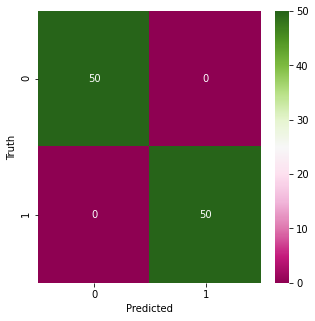

In [ ]:
# evaluating the performance of unsupervised classification
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score,precision_score,recall_score

acc = accuracy_score(Y_test,Y_pred)
pres = precision_score(Y_test,Y_pred)
recall = recall_score(Y_test,Y_pred)
cm = confusion_matrix(Y_test,Y_pred)

print("accuracy = ",acc)
print("precision = ",pres)
print("recall score = ",recall)

import seaborn as sns
plt.figure(figsize=(5,5))
sns.heatmap(cm,annot=True,fmt='d',cmap='PiYG')
plt.xlabel('Predicted')
plt.ylabel('Truth')

# Visualizing images generated in cluster 0 and cluster 1

In [ ]:
img_list = []
for i in c1:

  img = cv2.imread("/content/drive/MyDrive/Mini Project/dataset100_all"+"/"+original_images_list[i])
  img1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  img_list.append(img1)

rows = 8
columns = 9
fig = plt.figure(figsize=(20,20))
#fig.subplots_adjust(hspace=0.5, wspace=0.5)

for j in range(1,rows*columns+1):
  img = img_list[j-1]
  fig.add_subplot(rows,columns,j)
  plt.imshow(img)

  if j == 69:
    break
plt.title("images with kmeans label 1")

In [ ]:
img_list = []
for i in c0:

  img = cv2.imread("/content/drive/MyDrive/Mini Project/dataset100_all"+"/"+original_images_list[i])
  img1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  img_list.append(img1)

rows = 8
columns = 9
fig = plt.figure(figsize=(20,20))
#fig.subplots_adjust(hspace=0.5, wspace=0.5)

for j in range(1,rows*columns+1):
  img = img_list[j-1]
  fig.add_subplot(rows,columns,j)
  plt.imshow(img)

  if j == 31:
    break
plt.title("images with kmeans label 0")
